![Alt text](images\paris_station_image.png)


# 🌦️ Predicting Weather in Paris Using Other Weather Stations

**AMDOUNI Wiem - BESBES Mohamed Amine - BLEL Roua - MKAOUAR Yassine - MANI Rania - ZOUAGHI Ahmed Semah**

### 🏆 **Challenge Overview**
The goal of this project is to **predict the weather conditions in Paris** using data from 5 weather stations (**Paris, Brest, London, Marseille, and Berlin**). 

🚨 **Problem Statement:**  
- The **Paris weather station** has **broken down**.
- Can we use data from other stations to **accurately estimate the weather in Paris**?

### 📊 **Dataset Overview**

#### 🌍 Surface Variables

| **Variable** | **Description** |
|-------------|----------------|
| **skt**  | Skin temperature |
| **u10**  | 10m wind speed (U component) |
| **v10**  | 10m wind speed (V component) |
| **t2m**  | 2m temperature |
| **d2m**  | 2m de point temperature |
| **tcc**  | Total cloud cover |
| **sp**   | Surface pressure |
| **tp**   | Total precipitation |
| **ssrd** | Surface solar radiation downwards |
| **blh**  | Boundary layer height |


##### ⏳ **Temporal & Spatial Resolution:**
- **Temporal resolution:** Hourly ⏰  
- **Spatial resolution:** N/A 🌍

### 🚀 **First Steps**

🔹 **Analyze Variable Relationships** → Identify correlations between different weather variables.  
🔹 **Define the Prediction Target** → Which variable should we predict? (`tcc`, `tp`, etc.)  
🔹 **Choose a Time Scale** → Are we predicting hourly, daily, or long-term trends?  
🔹 **Start with Simpler Predictions** → Validate the model on easier variables before tackling complex ones.  
🔹 **Assess Predictability** → Are certain weather events more predictable than others? 

## Importing librairies

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

## Reading all data

In [2]:
from pathlib import Path
import pandas as pd
import xarray as xr

dir0 = Path('weather/')
stations = ['paris', 'brest', 'london', 'marseille', 'berlin']
variables = ['t2m', 'tp', 'skt', 'u10', 'v10', 'd2m', 'blh', 'sp', 'ssrd' , 'tcc' ]

# Function to load the data
def load_station_data(station):
    station_data = {}
    for var in variables:
        file_path = dir0 / station / f"{var}.nc"
        if file_path.exists():
            ds = xr.open_dataset(file_path)
            df = ds.to_dataframe().reset_index()
            df = df.set_index('time')
            station_data[var] = df[[var]]
    if station_data:
        common_index = pd.concat(station_data.values(), axis=0).index.unique()
        station_data_aligned = {k: v.reindex(common_index) for k, v in station_data.items()}
        merged_df = pd.concat(station_data_aligned.values(), axis=1)
        merged_df.columns = station_data.keys()
        return merged_df
    return None

# Loading the data for each station
df_paris = load_station_data('paris')
df_brest = load_station_data('brest')
df_london = load_station_data('london')
df_marseille = load_station_data('marseille')
df_berlin = load_station_data('berlin')

In [3]:
df_london.head()

t2m  tp         skt  ...             sp  ssrd       tcc
time                                             ...                               
1980-01-01 00:00:00  271.648010 NaN  270.567810  ...  100375.015625   NaN  0.632019
1980-01-01 01:00:00  271.235352 NaN  270.226288  ...  100341.843750   NaN  0.918030
1980-01-01 02:00:00  270.897797 NaN  270.074280  ...  100334.453125   NaN  0.970001
1980-01-01 03:00:00  270.847168 NaN  269.962280  ...  100338.320312   NaN  0.950012
1980-01-01 04:00:00  270.771301 NaN  269.985931  ...  100308.750000   NaN  0.961792

[5 rows x 10 columns]

In [4]:
df_paris.columns

Index(['t2m', 'tp', 'skt', 'u10', 'v10', 'd2m', 'blh', 'sp', 'ssrd', 'tcc'], dtype='object')

In [5]:
df_paris.describe()

t2m             tp  ...          ssrd            tcc
count  359424.000000  359424.000000  ...  3.594240e+05  359424.000000
mean      284.404175       0.000082  ...  4.776326e+05       0.664978
std         7.122195       0.000297  ...  7.350204e+05       0.369280
min       256.771332       0.000000  ... -1.901566e+00       0.000000
25%       279.366882       0.000000  ...  0.000000e+00       0.347229
50%       284.210266       0.000000  ...  2.099200e+04       0.842072
75%       289.264038       0.000009  ...  7.504640e+05       0.998413
max       314.154785       0.011550  ...  3.315712e+06       1.000000

[8 rows x 10 columns]

## Inter-ville correlation

In [ ]:
for c in df_paris.columns:
    df_combined = pd.concat([df_paris[c], df_brest[c], df_london[c], df_marseille[c], df_berlin[c]], axis=1)
    df_combined.columns = ['paris', 'brest', 'london', 'marseille', 'berlin']
    corr_matrix = df_combined.corr()
    print('\n')
    print(c)
    print(corr_matrix)



t2m
              paris     brest    london  marseille    berlin
paris      1.000000  0.889973  0.925401   0.880394  0.875767
brest      0.889973  1.000000  0.910519   0.837348  0.790369
london     0.925401  0.910519  1.000000   0.846232  0.849524
marseille  0.880394  0.837348  0.846232   1.000000  0.850032
berlin     0.875767  0.790369  0.849524   0.850032  1.000000


tp
              paris     brest    london  marseille    berlin
paris      1.000000  0.067990  0.133464   0.040394  0.022611
brest      0.067990  1.000000  0.149862   0.018156 -0.001081
london     0.133464  0.149862  1.000000   0.026990 -0.003144
marseille  0.040394  0.018156  0.026990   1.000000 -0.023790
berlin     0.022611 -0.001081 -0.003144  -0.023790  1.000000


skt
              paris     brest    london  marseille    berlin
paris      1.000000  0.917585  0.932248   0.876794  0.886263
brest      0.917585  1.000000  0.930056   0.878482  0.838375
london     0.932248  0.930056  1.000000   0.849066  0.866218
marseil

## Intra-ville correlation

In [ ]:
correlation_matrix = df_paris.corr()
correlation_matrix

t2m        tp       skt       u10       v10       d2m       blh  \
t2m   1.000000  0.020438  0.972195  0.042646  0.039966  0.866857  0.379216   
tp    0.020438  1.000000  0.015884  0.105478  0.140365  0.117461  0.059716   
skt   0.972195  0.015884  1.000000  0.015650  0.008641  0.819659  0.427805   
u10   0.042646  0.105478  0.015650  1.000000  0.339233  0.147059  0.335316   
v10   0.039966  0.140365  0.008641  0.339233  1.000000  0.143507  0.081386   
d2m   0.866857  0.117461  0.819659  0.147059  0.143507  1.000000  0.101559   
blh   0.379216  0.059716  0.427805  0.335316  0.081386  0.101559  1.000000   
sp   -0.091366 -0.262241 -0.065885 -0.231309 -0.362870 -0.156564 -0.218335   
ssrd  0.518303 -0.053044  0.645129 -0.078823 -0.096294  0.204058  0.596779   
tcc  -0.054926  0.200135 -0.049674  0.234452  0.219707  0.086632  0.117861   

            sp      ssrd       tcc  
t2m  -0.091366  0.518303 -0.054926  
tp   -0.262241 -0.053044  0.200135  
skt  -0.065885  0.645129 -0.049674  
u10  -0.231309 -0.078823  0.234452  
v10  -0.362870 -0.096294  0.219707  
d2m  -0.156564  0.204058  0.086632  
blh  -0.218335  0.596779  0.117861  
sp    1.000000  0.039054 -0.233936  
ssrd  0.039054  1.000000 -0.131210  
tcc  -0.233936 -0.131210  1.000000

## Combination of all variables into a single DataFrame, excluding Paris data, which is kept as the target.

In [6]:
# We add the city suffix to DataFrame columns
def rename_columns_with_city(df, city_name):
    return df.rename(columns=lambda col: f"{col}_{city_name}")

df_brest = rename_columns_with_city(df_brest, "brest")
df_london = rename_columns_with_city(df_london, "london")
df_marseille = rename_columns_with_city(df_marseille, "marseille")
df_berlin = rename_columns_with_city(df_berlin, "berlin")
df_paris = rename_columns_with_city(df_paris, "paris")

# We create the DataFrame : features X and target y
X = pd.concat([df_brest, df_london, df_marseille, df_berlin], axis=1)

## Handling missing values

In [7]:
X.head(4)

t2m_brest  tp_brest  ...  ssrd_berlin  tcc_berlin
time                                       ...                         
1980-01-01 00:00:00  278.646057       NaN  ...          NaN    0.916779
1980-01-01 01:00:00  278.666992       NaN  ...          NaN    0.863159
1980-01-01 02:00:00  278.604828       NaN  ...          NaN    0.863678
1980-01-01 03:00:00  278.364746       NaN  ...          NaN    0.792236

[4 rows x 40 columns]

In [8]:
X.isna().sum()

t2m_brest         7
tp_brest          7
skt_brest         7
u10_brest         7
v10_brest         7
d2m_brest         7
blh_brest         7
sp_brest          7
ssrd_brest        7
tcc_brest         7
t2m_london        7
tp_london         7
skt_london        7
u10_london        7
v10_london        7
d2m_london        7
blh_london        7
sp_london         7
ssrd_london       7
tcc_london        7
t2m_marseille     7
tp_marseille      7
skt_marseille     7
u10_marseille     7
v10_marseille     7
d2m_marseille     7
blh_marseille     7
sp_marseille      7
ssrd_marseille    7
tcc_marseille     7
t2m_berlin        7
tp_berlin         7
skt_berlin        7
u10_berlin        7
v10_berlin        7
d2m_berlin        7
blh_berlin        7
sp_berlin         7
ssrd_berlin       7
tcc_berlin        7
dtype: int64

In [9]:
df_paris.isna().sum()

t2m_paris     7
tp_paris      7
skt_paris     7
u10_paris     7
v10_paris     7
d2m_paris     7
blh_paris     7
sp_paris      7
ssrd_paris    7
tcc_paris     7
dtype: int64

As the number of missing values is negligible compared to the total amount of data, we will remove them.

In [10]:
X.dropna(inplace=True)
df_paris.dropna(inplace=True)

## We calculate the number of zeros in each column

### For the explanatory variables

In [11]:
# We calculate the number of zeros per column.
zeros_per_column = (X == 0).sum()

# We calculate the total number of values per column.
total_values_per_column = X.count()

# ratio of zeros per column
zero_ratio = zeros_per_column / total_values_per_column

result = pd.DataFrame({
    'Zeros Count': zeros_per_column,
    'Total Values': total_values_per_column,
    'Zero Ratio': zero_ratio
})

print(result)

                Zeros Count  Total Values  Zero Ratio
t2m_brest                 0        350633    0.000000
tp_brest             192188        350633    0.548117
skt_brest                 0        350633    0.000000
u10_brest                 0        350633    0.000000
v10_brest                 0        350633    0.000000
d2m_brest                 0        350633    0.000000
blh_brest                 0        350633    0.000000
sp_brest                  0        350633    0.000000
ssrd_brest           160066        350633    0.456506
tcc_brest             12771        350633    0.036423
t2m_london                0        350633    0.000000
tp_london            229778        350633    0.655323
skt_london                0        350633    0.000000
u10_london                1        350633    0.000003
v10_london                1        350633    0.000003
d2m_london                0        350633    0.000000
blh_london                0        350633    0.000000
sp_london                 0 

### For the target variables: Paris

In [12]:
# Same for paris
zeros_per_column_paris = (df_paris == 0).sum()

total_values_per_column_paris = df_paris.count()

zero_ratio_paris = zeros_per_column_paris / total_values_per_column_paris

result = pd.DataFrame({
    'Zeros Count': zeros_per_column_paris,
    'Total Values': total_values_per_column_paris,
    'Zero Ratio': zero_ratio_paris
})

print(result)

            Zeros Count  Total Values  Zero Ratio
t2m_paris             0        359417    0.000000
tp_paris         236982        359417    0.659351
skt_paris             0        359417    0.000000
u10_paris             1        359417    0.000003
v10_paris             0        359417    0.000000
d2m_paris             0        359417    0.000000
blh_paris             0        359417    0.000000
sp_paris              0        359417    0.000000
ssrd_paris       164634        359417    0.458058
tcc_paris         24548        359417    0.068299


## Detecting whether there are outliers

In [13]:
for c in X.columns:
    print(c)
    print(X[c].describe())

t2m_brest
count    350633.000000
mean        285.042267
std           4.206890
min         266.545654
25%         282.226990
50%         284.986023
75%         288.057617
max         304.947449
Name: t2m_brest, dtype: float64
tp_brest
count    350633.000000
mean          0.000104
std           0.000320
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000053
max           0.009577
Name: tp_brest, dtype: float64
skt_brest
count    350633.000000
mean        285.286835
std           4.394971
min         268.572327
25%         282.132355
50%         284.920105
75%         288.187988
max         305.868896
Name: skt_brest, dtype: float64
u10_brest
count    350633.000000
mean          1.326230
std           4.228701
min         -11.726608
25%          -1.889145
50%           1.374191
75%           4.275879
max          21.111069
Name: u10_brest, dtype: float64
v10_brest
count    350633.000000
mean          0.247948
std           4.248537
min         -15.397

t2m is typically between 268 K and 313 K.
tp is typically between 0 mm and 50 mm (per day).
skt is typically between 270 K and 320 K.
u10 and v10 are typically between  -20 m/s and 20 m/s.
d2m  is typically between 250 K and 300 K
blh is typically between 0 m and 3,000 m.
sp is typically between  950 hPa and 1050 hPa
ssrd is typically between 0 W/m² and 1,000 W/m².
tcc is typically between 0 and 1

##### Thus, we conclude that all values are normal, and there are no outliers.

## Daily Data

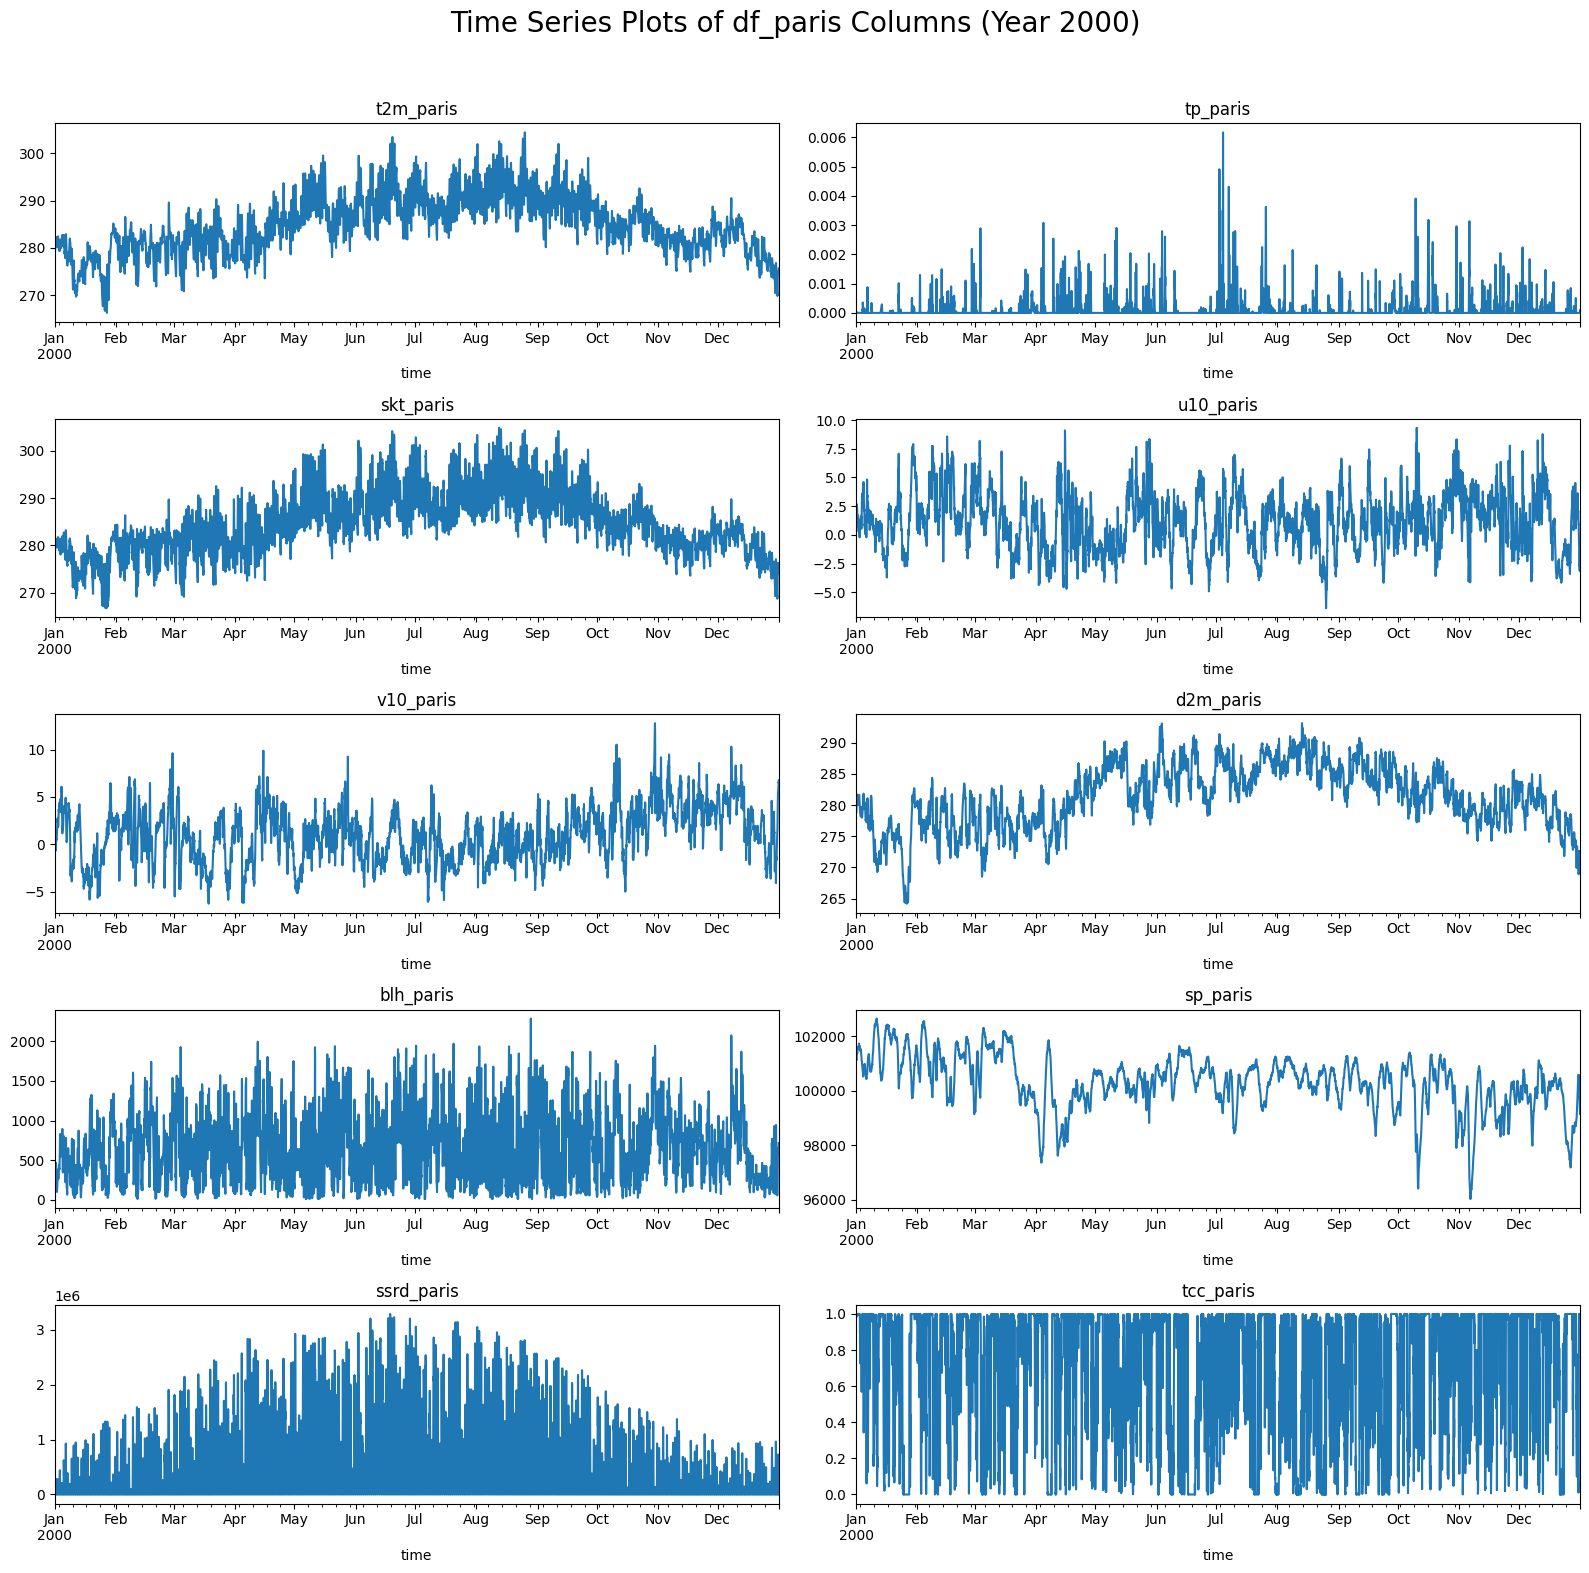

In [17]:
plt.figure(figsize=(16, 16))
plt.suptitle("Time Series Plots of df_paris Columns (Year 2000)", fontsize=20)  # Global title

for i, c in enumerate(df_paris.columns):
    plt.subplot(5, 2, i + 1)
    df_paris[c][df_paris[c].index.year == 2000].plot()
    plt.title(c)  # Set title for each subplot

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the global title
plt.show()

As observed, there are many fluctuations caused by variations, particularly the sudden changes that occur during certain hours of the day. 

Those fluctuations and noise observed in the hourly data make it challenging to analyze trends effectively. This is why we aggregate the data into daily intervals to smooth out the variations and focus on broader patterns.

### To obtain smoother data, we aggregate it into daily data.

In [15]:
df_paris_day = df_paris.resample('D').mean()
X_day = X.resample('D').mean()

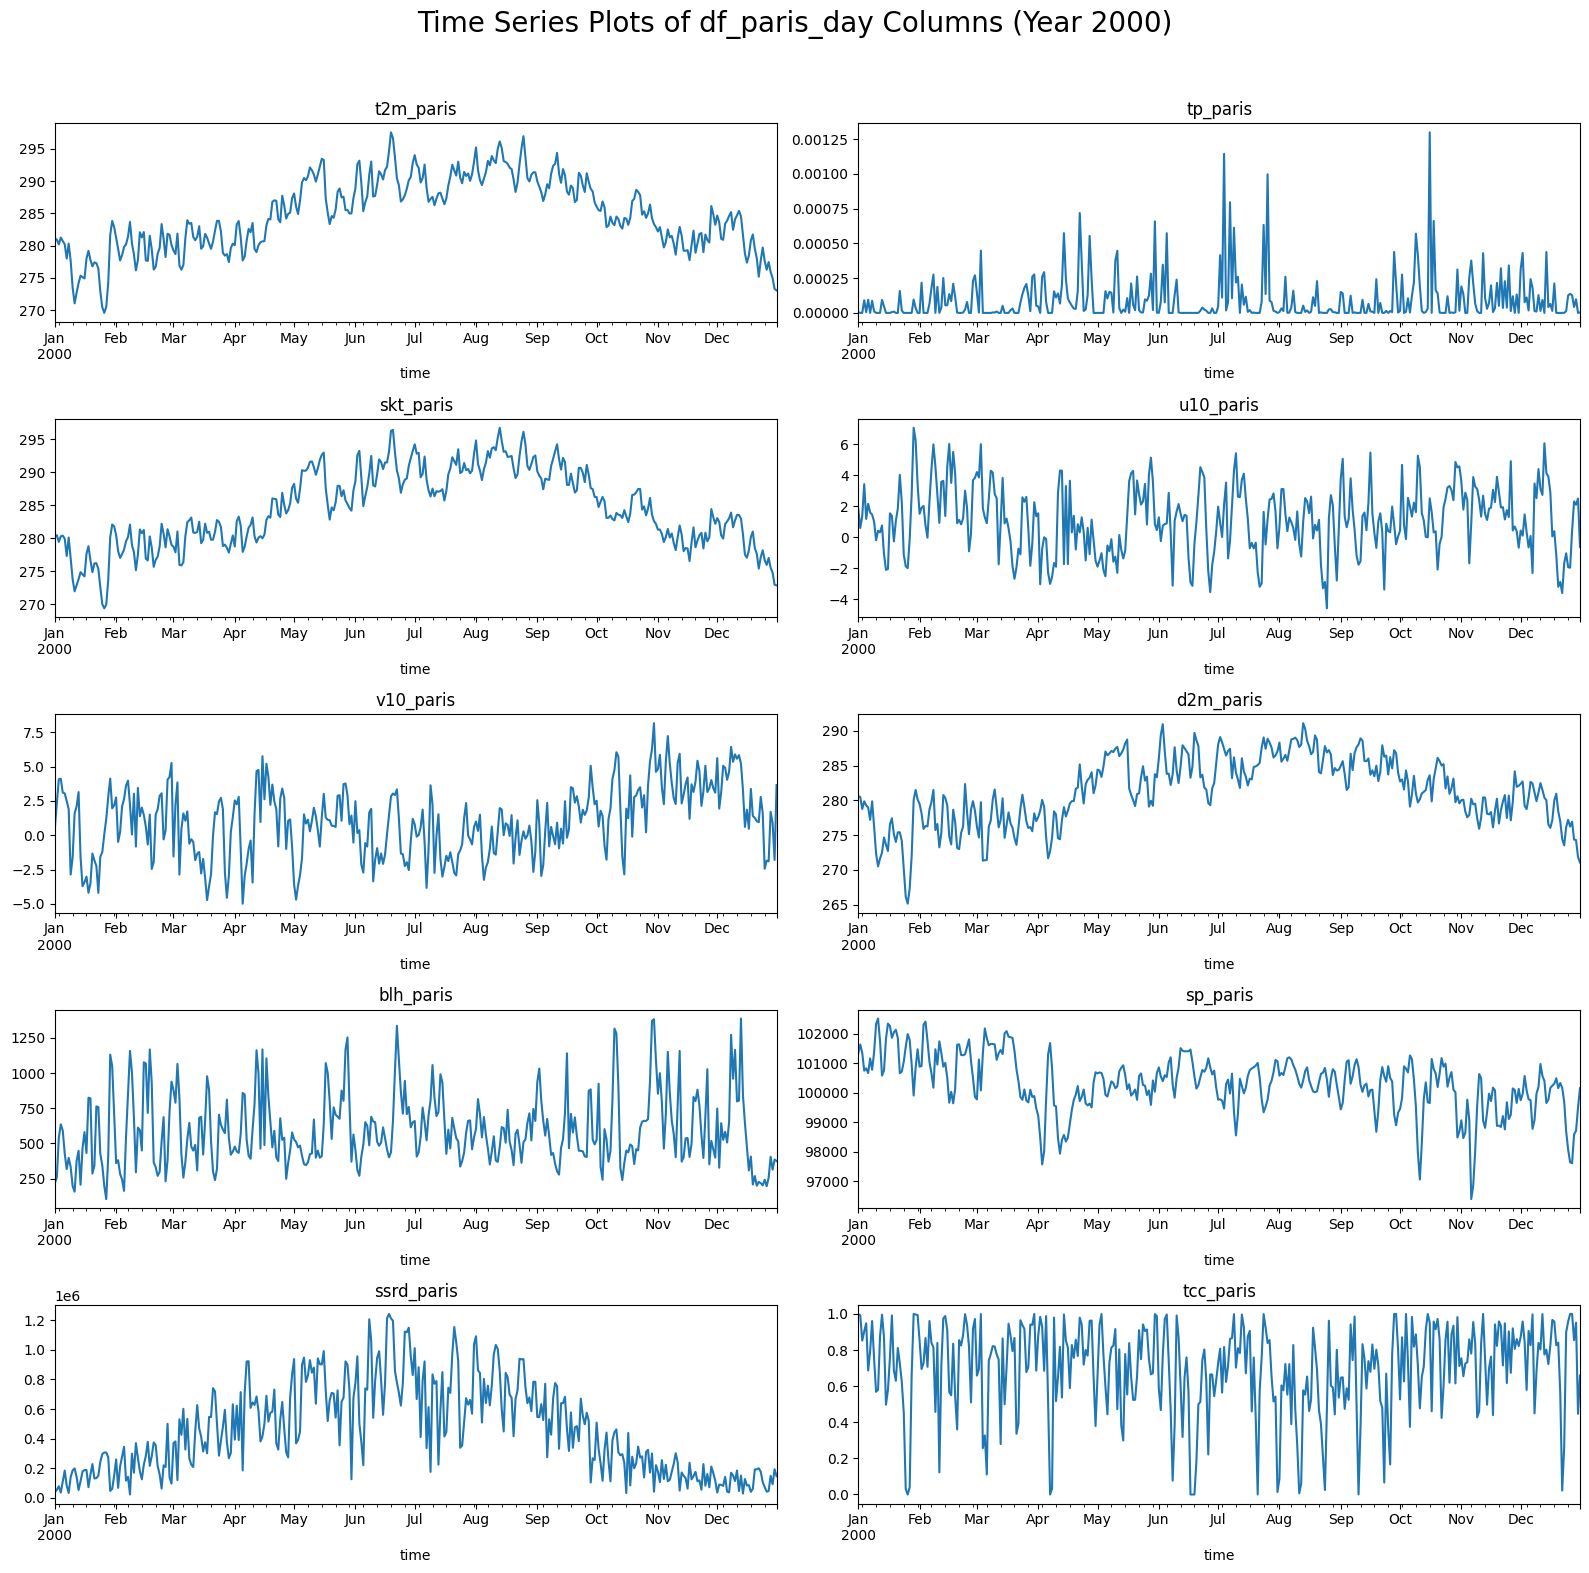

In [18]:
plt.figure(figsize=(16, 16))
plt.suptitle("Time Series Plots of df_paris_day Columns (Year 2000)", fontsize=20)  # Global title

for i, c in enumerate(df_paris_day.columns):
    plt.subplot(5, 2, i + 1)
    df_paris_day[c][df_paris_day[c].index.year == 2000].plot()
    plt.title(c)  # Set title for each subplot

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the global title
plt.show()

### Data distribution for each variable, in hourly and daily cases.

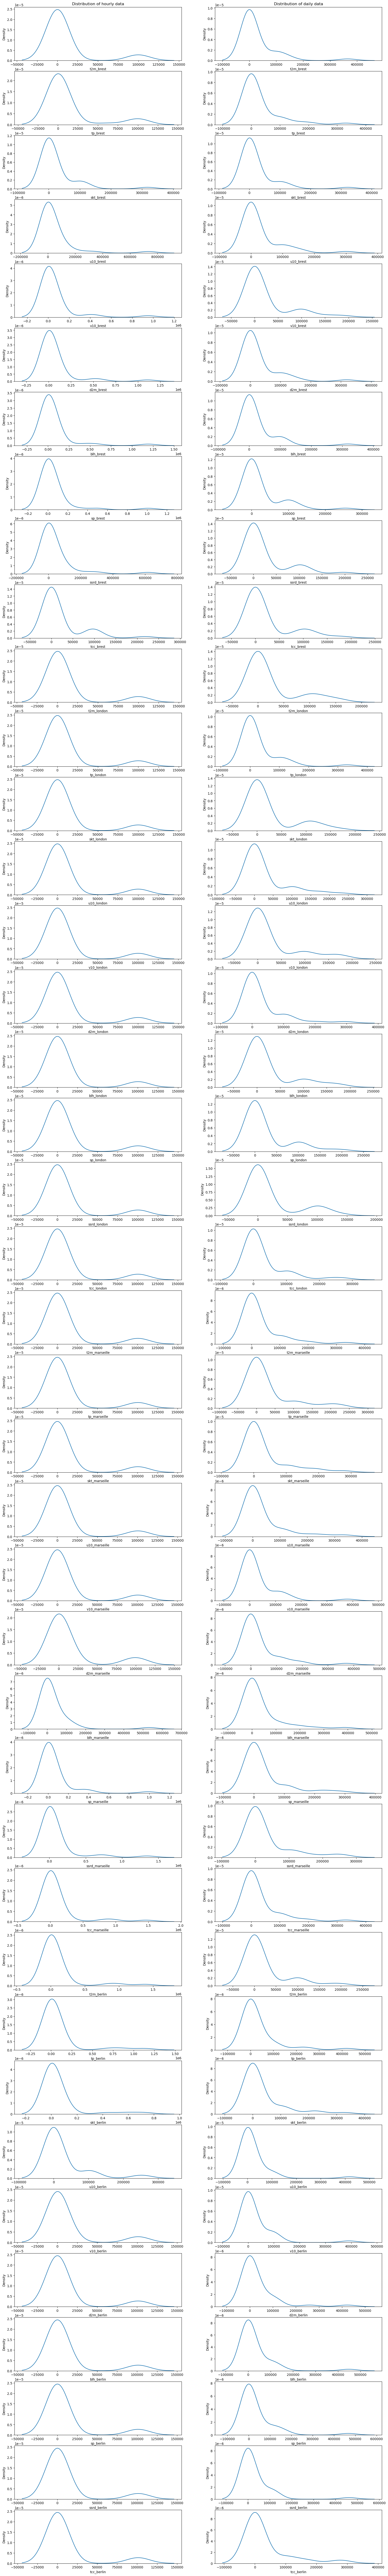

In [ ]:
plt.figure(figsize=(20,140))
plt.subplot(X.shape[1],2,1)
sns.kdeplot(X.iloc[0])
plt.title('Distribution of hourly data')
plt.xlabel(X.columns[0])
plt.subplot(X.shape[1],2,2)
sns.kdeplot(X_day.iloc[0])
plt.xlabel(X.columns[0])
plt.title('Distribution of daily data')
j=3
for i in range (1, X.shape[1]): 
    plt.subplot(X.shape[1],2,j)
    sns.kdeplot(X.iloc[i])
    plt.xlabel(X.columns[i])
    plt.subplot(X.shape[1],2,j+1)
    sns.kdeplot(X_day.iloc[i])
    plt.xlabel(X.columns[i])
    j=j+2

As seen in almost all variables, in the hourly case, there are some extreme values caused by fluctuations during certain hours. 

Aggregation eliminates those extreme values, making the data more stable and efficient for capturing the average across one day.

## Modelling

In [30]:
X_day = X_day
Y_day = df_paris_day

# We align X_day and Y_day.
X_aligned, Y_aligned = X_day.align(Y_day, join='inner', axis=0)

# Dividing into en train and test
# Ensure index is datetime
X_aligned.index = pd.to_datetime(X_aligned.index)
Y_aligned.index = pd.to_datetime(Y_aligned.index)

# Sort by date
X_aligned = X_aligned.sort_index()
Y_aligned = Y_aligned.sort_index()

# Split Data Properly into Train and Test
split_ratio = 0.8  # 80% train, 20% test
split_index = int(len(X_aligned) * split_ratio)

X_train = X_aligned.iloc[:split_index]
Y_train = Y_aligned.iloc[:split_index]

X_test = X_aligned.iloc[split_index:]
Y_test = Y_aligned.iloc[split_index:]

# Multi-output linear regression model.
model = LinearRegression()
model.fit(X_train, Y_train)

# Predictions
Y_pred = model.predict(X_test)

# Evaluation per variable
rmse_values = {}
r2_values = {}

for i, var in enumerate(variables):
    rmse_val = root_mean_squared_error(Y_test[var + "_paris"], Y_pred[:, i])
    r2_val = r2_score(Y_test[var + "_paris"], Y_pred[:, i])
    rmse_values[var] = rmse_val
    r2_values[var] = r2_val
    print(f"{var}: RMSE={rmse_val}, R2={r2_val}")


t2m: RMSE=4.458075523376465, R2=0.5226958990097046
tp: RMSE=0.00013916708121541888, R2=0.1618620753288269
skt: RMSE=4.614840984344482, R2=0.5500273704528809
u10: RMSE=1.9924650192260742, R2=0.20418739318847656
v10: RMSE=1.9878530502319336, R2=0.39012569189071655
d2m: RMSE=4.325230598449707, R2=0.32351094484329224
blh: RMSE=229.09803771972656, R2=0.24958908557891846
sp: RMSE=223.471435546875, R2=0.9362322092056274
ssrd: RMSE=156826.09375, R2=0.7694104909896851
tcc: RMSE=0.24094229936599731, R2=0.2593050003051758


We can see that linear regression performs very well on 6 of the 10 variables to be predicted, so we'll see if it's possible to reduce the number of features used to speed up the program without too great a degradation in performance on 6 variables. For each variable, we will use the top ten variables it depends on. The number 10 was chosen after testing different values between 1 and 40 (the total number of variables), and ten was found to be the most appropriate. 

For the other 4 variables, we got resonable performance for ssrd, but there is still room for improvement. Blh and tcc showed moderate generalization with acceptable RMSE values considering the scale of the variables. 

However, for tp, the RMSE was very low, but the generalization was poor due to the highly imbalanced distribution and the significant proportion of zero values.

### Predicting u10

In [31]:
y_u10 = df_paris_day['u10_paris']  #'u10' as target

In [32]:
X_day.shape , y_u10.shape

((14610, 40), (14976,))

In [33]:
X_cleaned, y_u10_cleaned = X_day.align(y_u10, join='inner', axis=0)
print(X_cleaned.shape)
print(y_u10_cleaned.shape)

(14610, 40)
(14610,)


In [34]:
correlations_selected_u10 = X_cleaned.corrwith(y_u10_cleaned).sort_values(ascending=False)
print("Variables most correlated with u10_paris:")
print(correlations_selected_u10.head(10))

Variables most correlated with u10_paris:
u10_brest        0.833033
u10_london       0.831725
v10_berlin       0.528005
blh_brest        0.526864
u10_marseille    0.502751
blh_london       0.500670
tp_berlin        0.340884
u10_berlin       0.336452
tcc_berlin       0.270101
tcc_brest        0.258532
dtype: float64


In [35]:
selected_features_u10 = correlations_selected_u10.head(10).index
X_selected_u10 = X_cleaned[selected_features_u10]
y_u10_selected = y_u10_cleaned
X_train_u10, X_test_u10, y_train_u10, y_test_u10 = train_test_split(X_selected_u10, y_u10_selected, test_size=0.2, random_state=42)
model_u10 = LinearRegression()
model_u10.fit(X_train_u10, y_train_u10)
y_pred_u10_train = model_u10.predict(X_train_u10)
y_pred_u10 = model_u10.predict(X_test_u10)

rmse_u10_train = root_mean_squared_error(y_train_u10, y_pred_u10_train)
r2_u10_train = r2_score(y_train_u10, y_pred_u10_train)

rmse_u10 = root_mean_squared_error(y_test_u10, y_pred_u10)
r2_u10 = r2_score(y_test_u10, y_pred_u10)

print(f"RMSE_train: {rmse_u10_train}")
print(f"R2_train: {r2_u10_train}")

print(f"RMSE: {rmse_u10}")
print(f"R2: {r2_u10}")

RMSE_train: 0.9511644244194031
R2_train: 0.8382513523101807
RMSE: 0.9514260292053223
R2: 0.8438958525657654


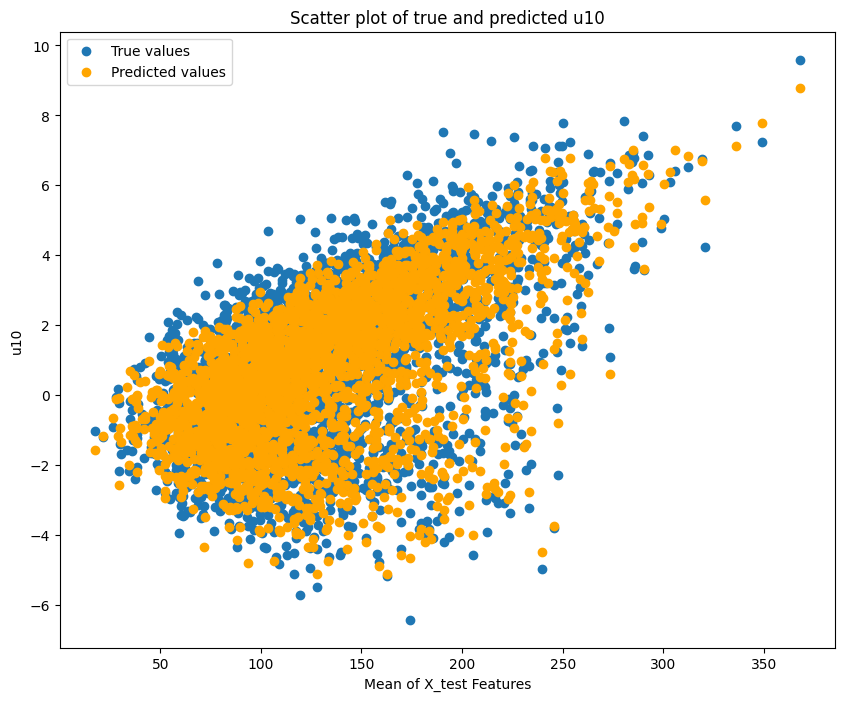

In [36]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_u10.mean(axis=1), y_test_u10, label='True values')
plt.scatter(X_test_u10.mean(axis=1), y_pred_u10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted u10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

Now, let's use a cross-validation approach.

In [37]:
model_u10_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_rmse_scores = cross_val_score(
    model_u10_cv,
    X_train_u10,
    y_train_u10,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_u10_cv,
    X_train_u10,
    y_train_u10,
    scoring='r2',
    cv=cv
)

# We calculate the mean and the standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_u10 = root_mean_squared_error(y_test_u10, y_pred_u10)
r2_u10 = r2_score(y_test_u10, y_pred_u10)

print(f"RMSE: {rmse_u10}")
print(f"R2: {r2_u10}")

Cross-validated RMSE: 0.9519 ± 0.0177
Cross-validated R²: 0.8378 ± 0.0072
RMSE: 0.9514260292053223
R2: 0.8438958525657654


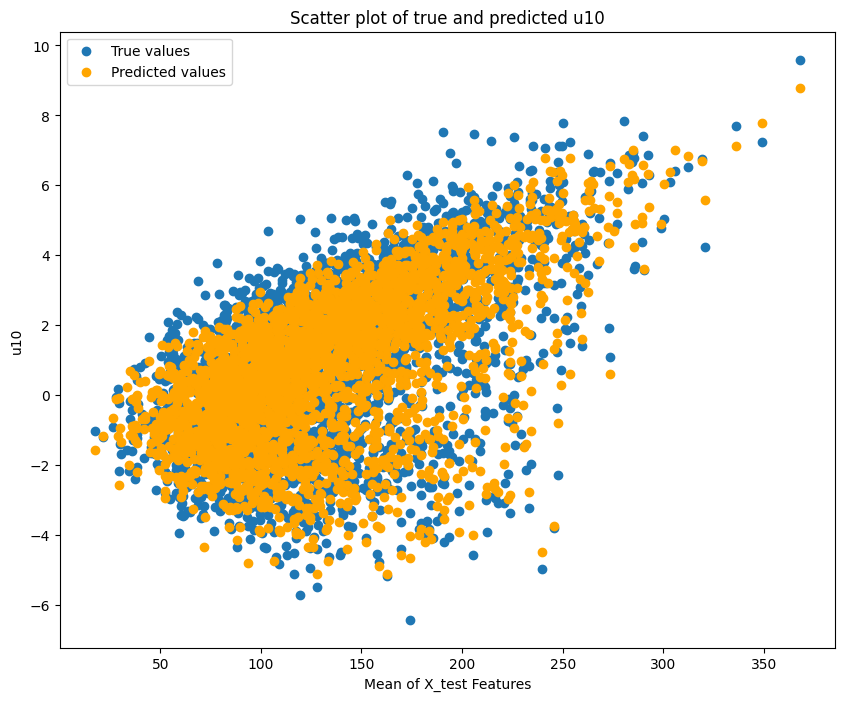

In [38]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_u10.mean(axis=1), y_test_u10, label='True values')
plt.scatter(X_test_u10.mean(axis=1), y_pred_u10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted u10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

We obtained close values, which indicates the model's consistency and robustness.

Now we repeat everything we did with the variable u10 for the other variables.

### Predicting v10

In [39]:
y_v10 = df_paris_day['v10_paris']  # 'v10' as target

In [40]:
X_day.shape , y_v10.shape

((14610, 40), (14976,))

In [41]:
X_cleaned, y_v10_cleaned = X_day.align(y_v10, join='inner', axis=0)
print(X_cleaned.shape)
print(y_v10_cleaned.shape)

(14610, 40)
(14610,)


In [42]:
correlations_selected_v10 = X_cleaned.corrwith(y_v10_cleaned).sort_values(ascending=False)
print("Variables most correlated with v10_paris:")
print(correlations_selected_v10.head(10))

Variables most correlated with v10_paris:
v10_london    0.755780
v10_brest     0.656717
u10_brest     0.650680
v10_berlin    0.650227
tp_brest      0.515498
tp_london     0.465317
tcc_brest     0.390910
blh_brest     0.348437
u10_london    0.319132
tcc_london    0.310578
dtype: float64


In [43]:
selected_features_v10 = correlations_selected_v10.head(10).index
X_selected_v10 = X_cleaned[selected_features_v10]
y_v10_selected = y_v10_cleaned
X_train_v10, X_test_v10, y_train_v10, y_test_v10 = train_test_split(X_selected_v10, y_v10_selected, test_size=0.2, random_state=42)

model_v10 = LinearRegression()
model_v10.fit(X_train_v10, y_train_v10)

y_pred_v10_train = model_v10.predict(X_train_v10)
y_pred_v10 = model_v10.predict(X_test_v10)

rmse_v10_train = root_mean_squared_error(y_train_v10, y_pred_v10_train)
r2_v10_train = r2_score(y_train_v10, y_pred_v10_train)

rmse_v10 = root_mean_squared_error(y_test_v10, y_pred_v10)
r2_v10 = r2_score(y_test_v10, y_pred_v10)

print(f"RMSE_train: {rmse_v10_train}")
print(f"R2_train: {r2_v10_train}")

print(f"RMSE: {rmse_v10}")
print(f"R2: {r2_v10}")

RMSE_train: 1.1907715797424316
R2_train: 0.7888187170028687
RMSE: 1.1966309547424316
R2: 0.7890491485595703


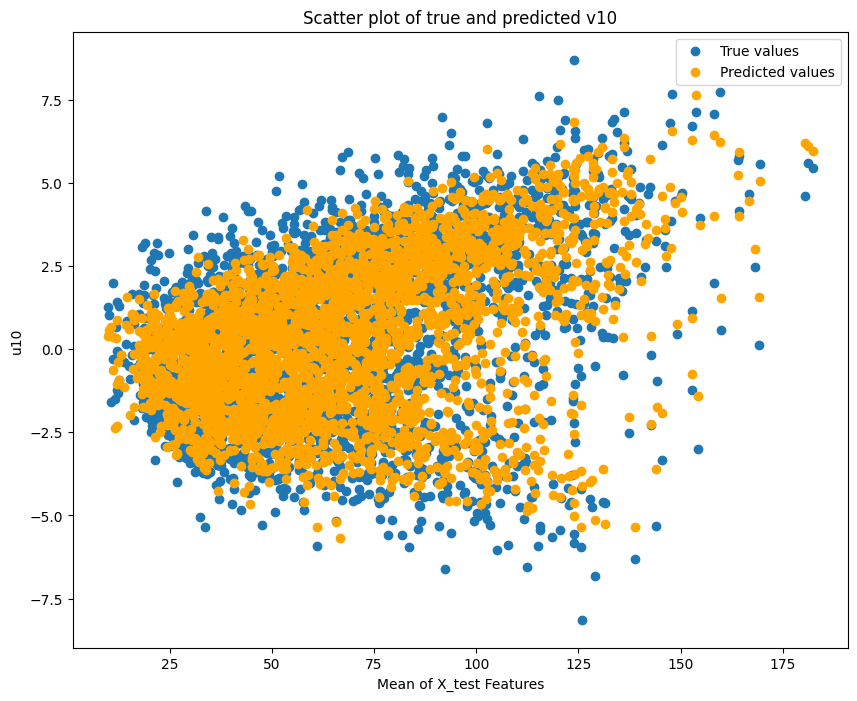

In [44]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_v10.mean(axis=1), y_test_v10, label='True values')
plt.scatter(X_test_v10.mean(axis=1), y_pred_v10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted v10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [45]:
model_v10_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_v10_cv,
    X_train_v10,
    y_train_v10,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_v10_cv,
    X_train_v10,
    y_train_v10,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_v10 = root_mean_squared_error(y_test_v10, y_pred_v10)
r2_v10 = r2_score(y_test_v10, y_pred_v10)

print(f"RMSE: {rmse_v10}")
print(f"R2: {r2_v10}")

Cross-validated RMSE: 1.1913 ± 0.0180
Cross-validated R²: 0.7885 ± 0.0057
RMSE: 1.1966309547424316
R2: 0.7890491485595703


### Predicting t2m

In [46]:
y_t2m = df_paris_day['t2m_paris']  #'t2m' as target

In [47]:
X_day.shape , y_t2m.shape

((14610, 40), (14976,))

In [48]:
X_cleaned, y_t2m_cleaned = X_day.align(y_t2m, join='inner', axis=0)
print(X_cleaned.shape)
print(y_t2m_cleaned.shape)

(14610, 40)
(14610,)


In [49]:
correlations_selected_t2m = X_cleaned.corrwith(y_t2m_cleaned).sort_values(ascending=False)
print("Variables most correlated with t2m_paris:")
print(correlations_selected_t2m.head(10))

Variables most correlated with t2m_paris:
skt_london       0.948663
t2m_london       0.946323
skt_brest        0.926436
t2m_brest        0.914815
t2m_marseille    0.906723
skt_berlin       0.905506
t2m_berlin       0.901263
skt_marseille    0.882933
d2m_london       0.880480
d2m_brest        0.869518
dtype: float64


In [50]:
selected_features_t2m = correlations_selected_t2m.head(10).index
X_selected_t2m = X_cleaned[selected_features_t2m]
y_t2m_selected = y_t2m_cleaned
X_train_t2m, X_test_t2m, y_train_t2m, y_test_t2m = train_test_split(X_selected_t2m, y_t2m_selected, test_size=0.2, random_state=42)

model_t2m = LinearRegression()
model_t2m.fit(X_train_t2m, y_train_t2m)

y_pred_t2m_train = model_t2m.predict(X_train_t2m)
y_pred_t2m = model_t2m.predict(X_test_t2m)

rmse_t2m_train = root_mean_squared_error(y_train_t2m, y_pred_t2m_train)
r2_t2m_train = r2_score(y_train_t2m, y_pred_t2m_train)

rmse_t2m = root_mean_squared_error(y_test_t2m, y_pred_t2m)
r2_t2m = r2_score(y_test_t2m, y_pred_t2m)

print(f"RMSE_train: {rmse_t2m_train}")
print(f"R2_train: {r2_t2m_train}")

print(f"RMSE: {rmse_t2m}")
print(f"R2: {r2_t2m}")

RMSE_train: 1.6447659730911255
R2_train: 0.9363926649093628
RMSE: 1.6131402254104614
R2: 0.9353973865509033


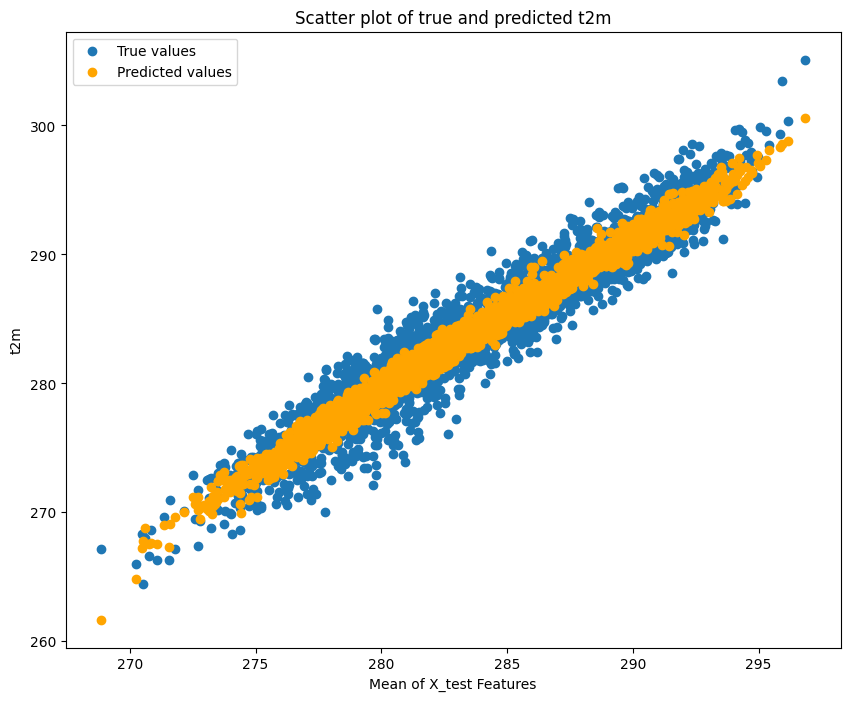

In [51]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_t2m.mean(axis=1), y_test_t2m, label='True values')
plt.scatter(X_test_t2m.mean(axis=1), y_pred_t2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted t2m')
plt.ylabel('t2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [52]:
model_t2m_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_t2m_cv,
    X_train_t2m,
    y_train_t2m,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_t2m_cv,
    X_train_t2m,
    y_train_t2m,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_t2m = root_mean_squared_error(y_test_t2m, y_pred_t2m)
r2_t2m = r2_score(y_test_t2m, y_pred_t2m)

print(f"RMSE: {rmse_t2m}")
print(f"R2: {r2_t2m}")

Cross-validated RMSE: 1.6470 ± 0.0139
Cross-validated R²: 0.9362 ± 0.0011
RMSE: 1.6131402254104614
R2: 0.9353973865509033


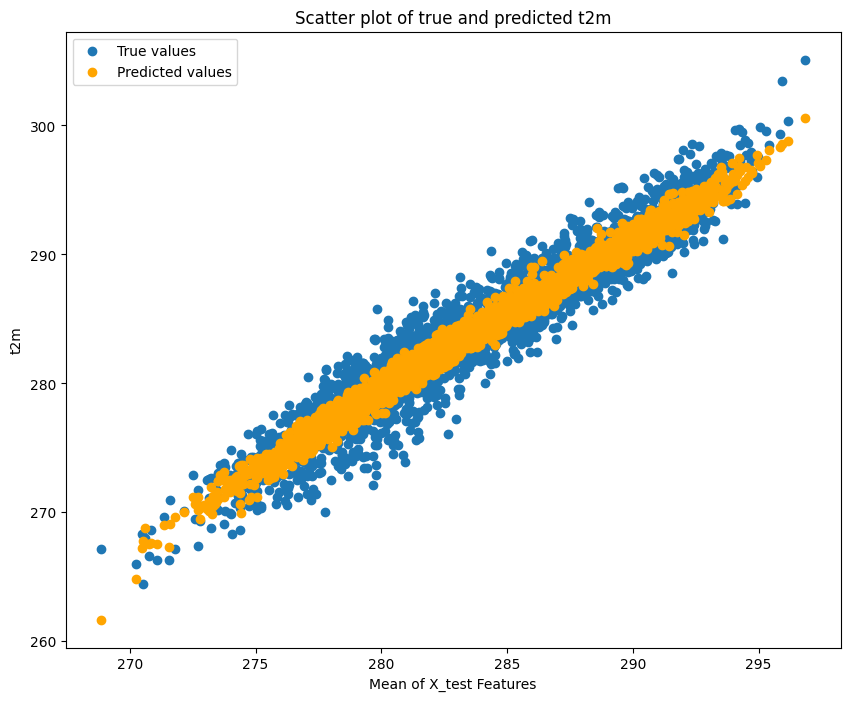

In [53]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_t2m.mean(axis=1), y_test_t2m, label='True values')
plt.scatter(X_test_t2m.mean(axis=1), y_pred_t2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted t2m')
plt.ylabel('t2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### Predicting d2m

In [54]:
y_d2m = df_paris_day['d2m_paris']  #'d2m' as target

In [55]:
X_day.shape , y_d2m.shape

((14610, 40), (14976,))

In [56]:
X_cleaned, y_d2m_cleaned = X_day.align(y_d2m, join='inner', axis=0)
print(X_cleaned.shape)
print(y_d2m_cleaned.shape)

(14610, 40)
(14610,)


In [57]:
correlations_selected_d2m = X_cleaned.corrwith(y_d2m_cleaned).sort_values(ascending=False)
print("Variables most correlated with d2m_paris:")
print(correlations_selected_d2m.head(10))

Variables most correlated with d2m_paris:
d2m_london       0.899240
d2m_brest        0.890039
t2m_london       0.888421
skt_london       0.881112
t2m_brest        0.877276
skt_brest        0.870049
t2m_berlin       0.847960
skt_berlin       0.845692
t2m_marseille    0.838234
d2m_berlin       0.829190
dtype: float64


In [58]:
selected_features_d2m = correlations_selected_d2m.head(10).index
X_selected_d2m = X_cleaned[selected_features_d2m]
y_d2m_selected = y_d2m_cleaned
X_train_d2m, X_test_d2m, y_train_d2m, y_test_d2m = train_test_split(X_selected_d2m, y_d2m_selected, test_size=0.2, random_state=42)

model_d2m = LinearRegression()
model_d2m.fit(X_train_d2m, y_train_d2m)

y_pred_d2m_train = model_d2m.predict(X_train_d2m)
y_pred_d2m = model_d2m.predict(X_test_d2m)

rmse_d2m_train = root_mean_squared_error(y_train_d2m, y_pred_d2m_train)
r2_d2m_train = r2_score(y_train_d2m, y_pred_d2m_train)

rmse_d2m = root_mean_squared_error(y_test_d2m, y_pred_d2m)
r2_d2m = r2_score(y_test_d2m, y_pred_d2m)

print(f"RMSE_train: {rmse_d2m_train}")
print(f"R2_train: {r2_d2m_train}")

print(f"RMSE: {rmse_d2m}")
print(f"R2: {r2_d2m}")

RMSE_train: 1.8878657817840576
R2_train: 0.8838224411010742
RMSE: 1.8641157150268555
R2: 0.8818366527557373


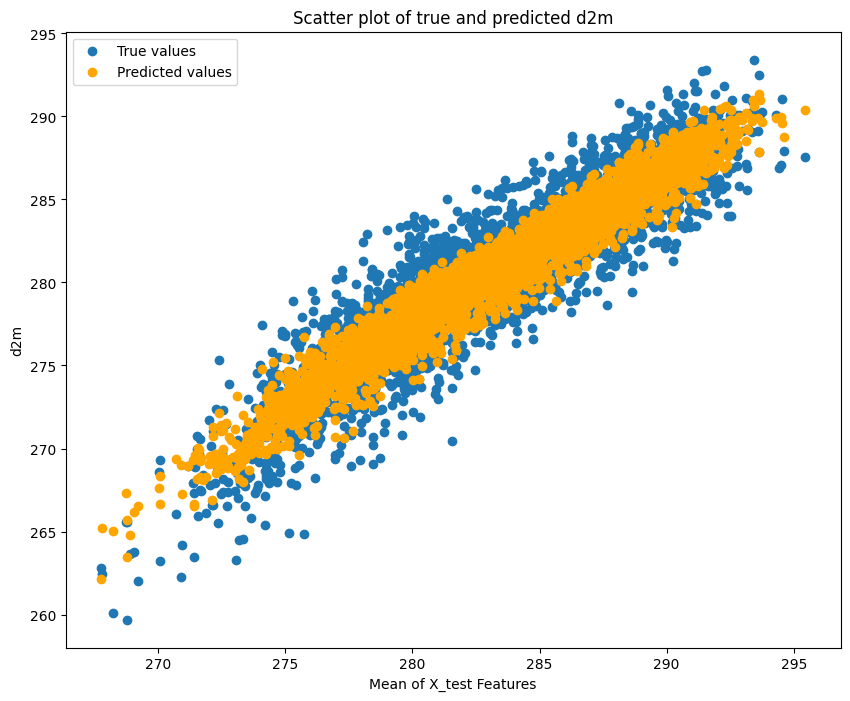

In [59]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_d2m.mean(axis=1), y_test_d2m, label='True values')
plt.scatter(X_test_d2m.mean(axis=1), y_pred_d2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted d2m')
plt.ylabel('d2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [60]:
model_d2m_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_d2m_cv,
    X_train_d2m,
    y_train_d2m,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_d2m_cv,
    X_train_d2m,
    y_train_d2m,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_d2m = root_mean_squared_error(y_test_d2m, y_pred_d2m)
r2_d2m = r2_score(y_test_d2m, y_pred_d2m)

print(f"RMSE: {rmse_d2m}")
print(f"R2: {r2_d2m}")

Cross-validated RMSE: 1.8896 ± 0.0176
Cross-validated R²: 0.8836 ± 0.0023
RMSE: 1.8641157150268555
R2: 0.8818366527557373


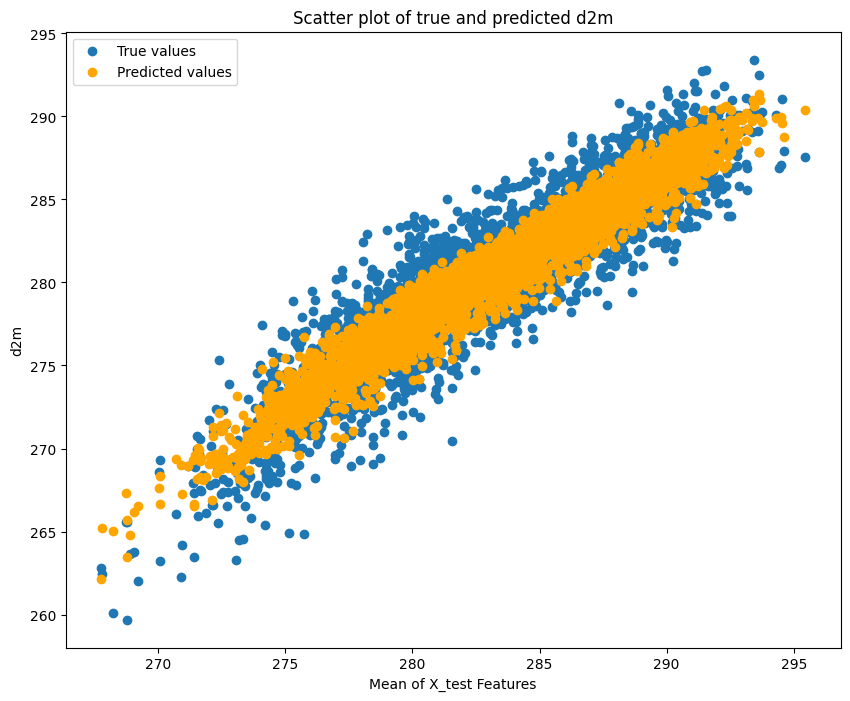

In [61]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_d2m.mean(axis=1), y_test_d2m, label='True values')
plt.scatter(X_test_d2m.mean(axis=1), y_pred_d2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted d2m')
plt.ylabel('d2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### Predicting skt

In [62]:
y_skt = df_paris_day['skt_paris']  #'skt' as target

In [63]:
X_day.shape , y_skt.shape

((14610, 40), (14976,))

In [64]:
X_cleaned, y_skt_cleaned = X_day.align(y_skt, join='inner', axis=0)
print(X_cleaned.shape)
print(y_skt_cleaned.shape)

(14610, 40)
(14610,)


In [65]:
correlations_selected_skt = X_cleaned.corrwith(y_skt_cleaned).sort_values(ascending=False)
print("Variables most correlated with skt_paris:")
print(correlations_selected_skt.head(10))

Variables most correlated with skt_paris:
skt_london       0.954457
t2m_london       0.946102
skt_brest        0.935574
t2m_marseille    0.921357
skt_berlin       0.915564
t2m_brest        0.913325
t2m_berlin       0.907171
skt_marseille    0.903640
d2m_london       0.873152
d2m_brest        0.861536
dtype: float64


In [66]:
selected_features_skt = correlations_selected_skt.head(10).index
X_selected_skt = X_cleaned[selected_features_skt]
y_skt_selected = y_skt_cleaned
X_train_skt, X_test_skt, y_train_skt, y_test_skt = train_test_split(X_selected_skt, y_skt_selected, test_size=0.2, random_state=42)

model_skt = LinearRegression()
model_skt.fit(X_train_skt, y_train_skt)

y_pred_skt_train = model_skt.predict(X_train_skt)
y_pred_skt = model_skt.predict(X_test_skt)

rmse_skt_train = root_mean_squared_error(y_train_skt, y_pred_skt_train)
r2_skt_train = r2_score(y_train_skt, y_pred_skt_train)

rmse_skt = root_mean_squared_error(y_test_skt, y_pred_skt)
r2_skt = r2_score(y_test_skt, y_pred_skt)

print(f"RMSE_train: {rmse_skt_train}")
print(f"R2_train: {r2_skt_train}")

print(f"RMSE: {rmse_skt}")
print(f"R2: {r2_skt}")

RMSE_train: 1.5930577516555786
R2_train: 0.9450036883354187
RMSE: 1.5558353662490845
R2: 0.9447551369667053


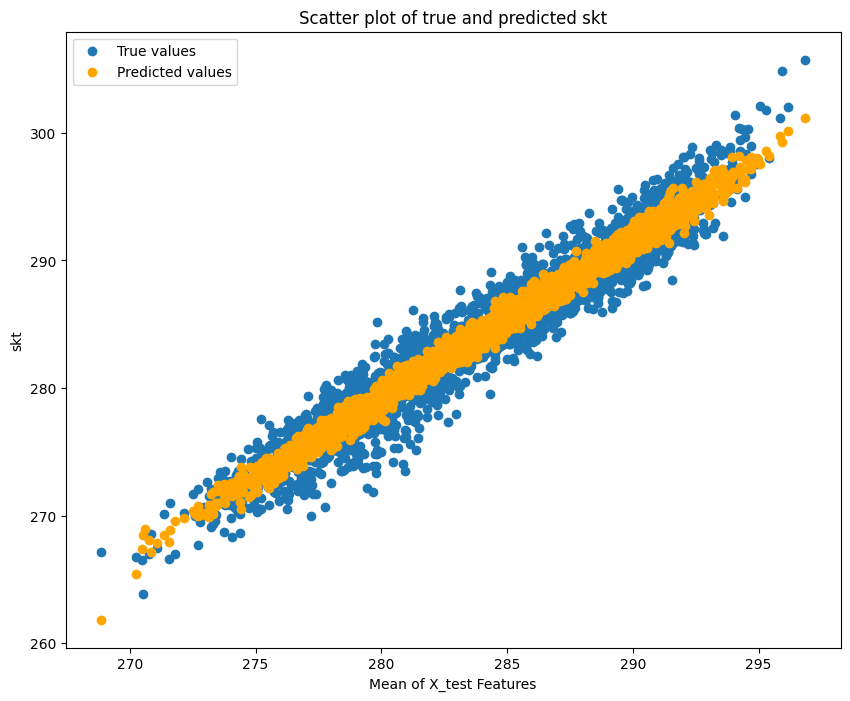

In [67]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_skt.mean(axis=1), y_test_skt, label='True values')
plt.scatter(X_test_skt.mean(axis=1), y_pred_skt, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted skt')
plt.ylabel('skt')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [68]:
model_skt_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_skt_cv,
    X_train_skt,
    y_train_skt,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_skt_cv,
    X_train_skt,
    y_train_skt,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_skt = root_mean_squared_error(y_test_skt, y_pred_skt)
r2_skt = r2_score(y_test_skt, y_pred_skt)

print(f"RMSE: {rmse_skt}")
print(f"R2: {r2_skt}")

Cross-validated RMSE: 1.5949 ± 0.0178
Cross-validated R²: 0.9448 ± 0.0011
RMSE: 1.5558353662490845
R2: 0.9447551369667053


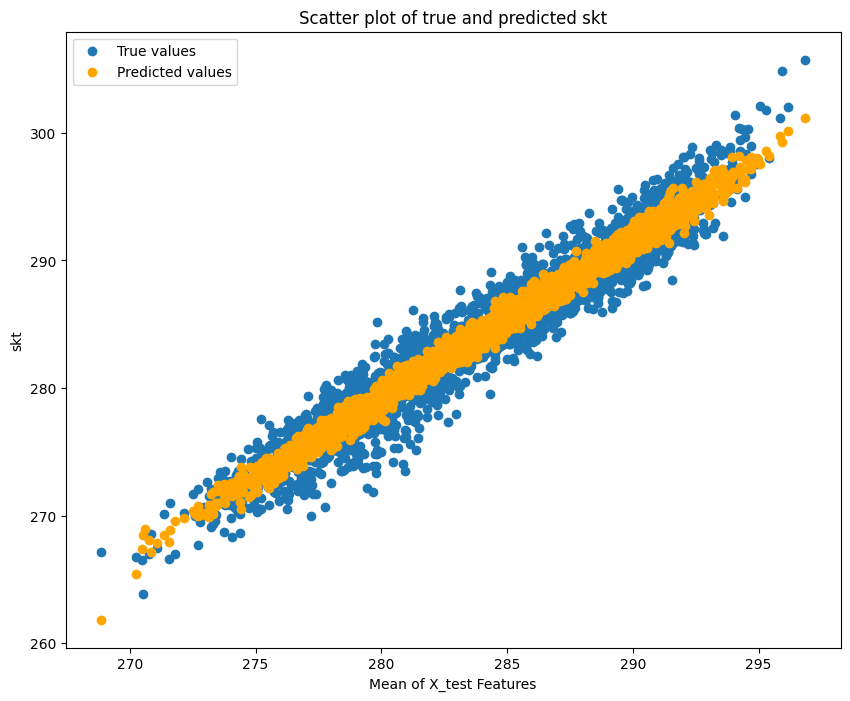

In [69]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_skt.mean(axis=1), y_test_skt, label='True values')
plt.scatter(X_test_skt.mean(axis=1), y_pred_skt, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted skt')
plt.ylabel('skt')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### predicting sp

In [70]:
y_sp = df_paris_day['sp_paris']  #'sp' as target

In [71]:
X_day.shape , y_sp.shape

((14610, 40), (14976,))

In [72]:
X_cleaned, y_sp_cleaned = X_day.align(y_sp, join='inner', axis=0)
print(X_cleaned.shape)
print(y_sp_cleaned.shape)

(14610, 40)
(14610,)


In [73]:
correlations_selected_sp = X_cleaned.corrwith(y_sp_cleaned).sort_values(ascending=False)
print("Variables most correlated with sp_paris:")
print(correlations_selected_sp.head(10))

Variables most correlated with sp_paris:
sp_brest          0.927659
sp_london         0.923764
sp_berlin         0.727092
sp_marseille      0.572915
u10_berlin        0.338996
blh_berlin        0.080628
ssrd_marseille    0.080332
u10_marseille     0.041604
u10_london        0.040902
ssrd_brest        0.036843
dtype: float64


In [74]:
selected_features_sp = correlations_selected_sp.head(10).index
X_selected_sp = X_cleaned[selected_features_sp]
y_sp_selected = y_sp_cleaned
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_selected_sp, y_sp_selected, test_size=0.2, random_state=42)

model_sp = LinearRegression()
model_sp.fit(X_train_sp, y_train_sp)

y_pred_sp_train = model_sp.predict(X_train_sp)
y_pred_sp = model_sp.predict(X_test_sp)

rmse_sp_train = root_mean_squared_error(y_train_sp, y_pred_sp_train)
r2_sp_train = r2_score(y_train_sp, y_pred_sp_train)

rmse_sp = root_mean_squared_error(y_test_sp, y_pred_sp)
r2_sp = r2_score(y_test_sp, y_pred_sp)

print(f"RMSE_train: {rmse_sp_train}")
print(f"R2_train: {r2_sp_train}")

print(f"RMSE: {rmse_sp}")
print(f"R2: {r2_sp}")

RMSE_train: 198.9867401123047
R2_train: 0.9487622380256653
RMSE: 195.26235961914062
R2: 0.9505358338356018


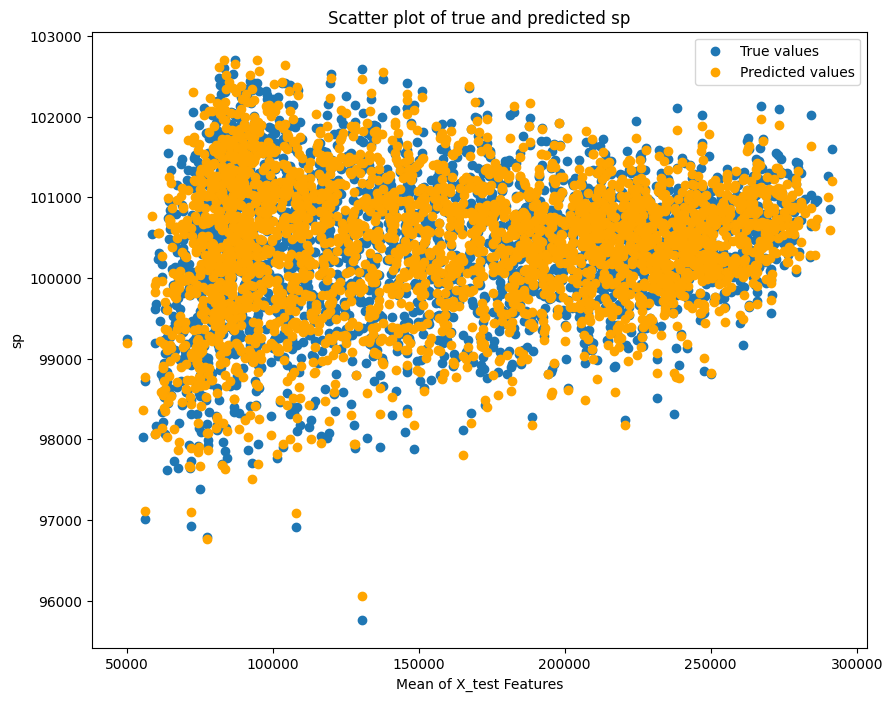

In [75]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_sp.mean(axis=1), y_test_sp, label='True values')
plt.scatter(X_test_sp.mean(axis=1), y_pred_sp, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted sp')
plt.ylabel('sp')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [76]:
model_sp_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_sp_cv,
    X_train_sp,
    y_train_sp,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_sp_cv,
    X_train_sp,
    y_train_sp,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_sp = root_mean_squared_error(y_test_sp, y_pred_sp)
r2_sp = r2_score(y_test_sp, y_pred_sp)

print(f"RMSE: {rmse_sp}")
print(f"R2: {r2_sp}")

Cross-validated RMSE: 199.1058 ± 1.4043
Cross-validated R²: 0.9487 ± 0.0013
RMSE: 195.26235961914062
R2: 0.9505358338356018


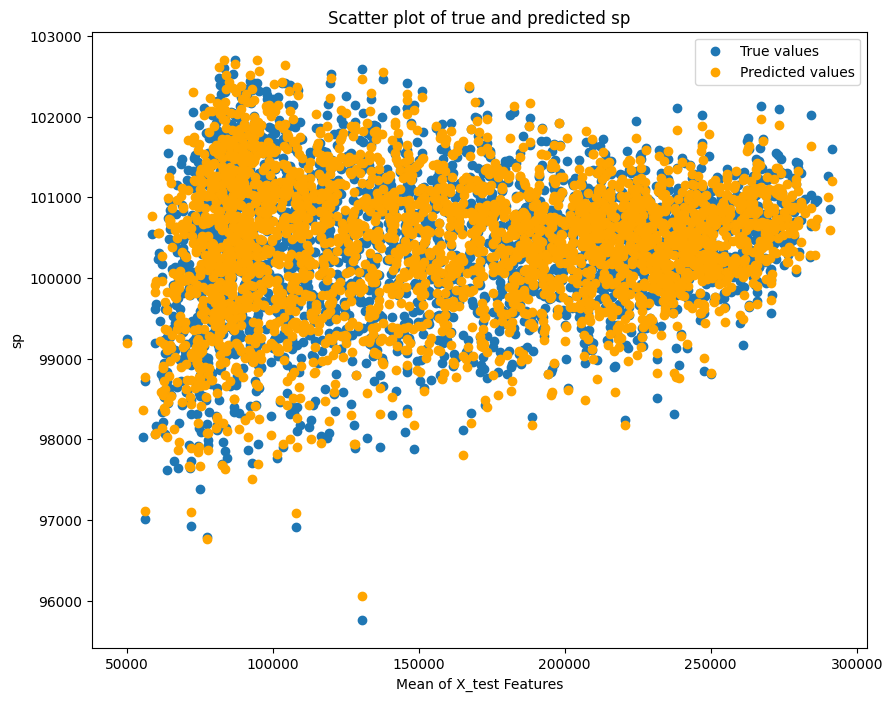

In [77]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_sp.mean(axis=1), y_test_sp, label='True values')
plt.scatter(X_test_sp.mean(axis=1), y_pred_sp, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted sp')
plt.ylabel('sp')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

##### Now, let's focus on the other four variables: ssrd, blh, tcc, and tp.

## Improve performances

At the beginning, we used GridSearchCV with several models, each tested with multiple variables. We observed that XGBoostRegressor was the most performant model, but the GridSearchCV process was very time-consuming. Therefore, we switched to RandomizedSearchCV with XGBoostRegressor and achieved almost the same results with a significantly shorter execution time compared to GridSearchCV.

In [78]:
# RandomizedSearchCV parameters
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Number of iterations and number of folds RandomizedSearchCV
n_iter_search = 20
cv_folds = 3

### Predicting ssrd

In [ ]:
# Target variable
var = 'ssrd_paris'

# Training initial model
initial_model_ssrd = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_ssrd.fit(X_train, Y_train[var])

# Initial predictions
preds_initial_ssrd = initial_model_ssrd.predict(X_test)

# Initiale evaluation
rmse_init_ssrd = root_mean_squared_error(Y_test[var], preds_initial_ssrd)
r2_init_ssrd = r2_score(Y_test[var], preds_initial_ssrd)
print(f"{var} - Initial: RMSE={rmse_init_ssrd:.4f}, R²={r2_init_ssrd:.4f}")

# Optimisation of hyperparameters
search_ssrd = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_ssrd.fit(X_train, Y_train[var])

# Best model
best_model_ssrd = search_ssrd.best_estimator_
best_model_ssrd.fit(X_train, Y_train[var])

# Otimized predictions
preds_best_ssrd = best_model_ssrd.predict(X_test)

# Evaluation
rmse_best_ssrd = root_mean_squared_error(Y_test[var], preds_best_ssrd)
r2_best_ssrd = r2_score(Y_test[var], preds_best_ssrd)
print(f"{var} - Optimisé: RMSE={rmse_best_ssrd:.4f}, R²={r2_best_ssrd:.4f}")
print(f"Meilleurs paramètres : {search_ssrd.best_params_}")

ssrd_paris - Initial: RMSE=129670.4375, R²=0.8338


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
57 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1143, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                     

ssrd_paris - Optimisé: RMSE=133750.9688, R²=0.8232
Meilleurs paramètres : {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


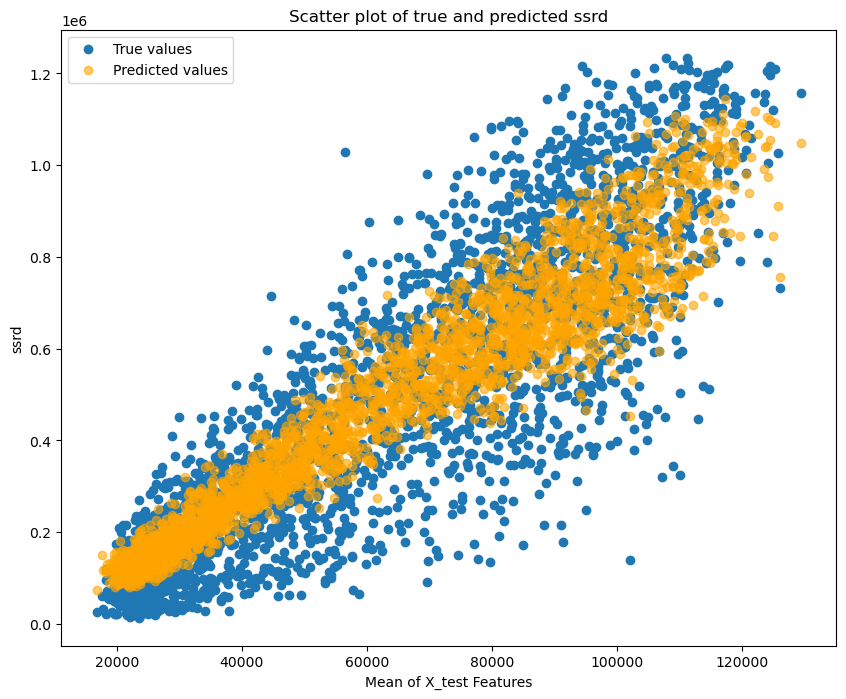

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_ssrd, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted ssrd')
plt.xlabel('Mean of X_test Features')
plt.ylabel('ssrd')
plt.legend()
plt.show()

As seen, we obtain strong performance for the ssrd model, with a reasonable RMSE considering the scale of the variable, and good consistency, demonstrating good generalization.

### Predicting blh

In [ ]:
# Trier les données par date au cas où
var = 'blh_paris'
X_aligned_blh = X_aligned.sort_index()
Y_aligned_blh = Y_aligned.sort_index()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

### ✅ 1. Définition de la variable cible ###
var = "blh_paris"

split_index = int(len(X_aligned_blh) * 0.8)
X_train_blh, X_test_blh = X_aligned_blh.iloc[:split_index], X_aligned_blh.iloc[split_index:]
Y_train_blh, Y_test_blh = Y_aligned_blh[var].iloc[:split_index], Y_aligned_blh[var].iloc[split_index:]

print(f"Taille X_train: {X_train_blh.shape}, Taille X_test: {X_test_blh.shape}")

### ✅ 3. Normalisation des Données ###
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_blh)
X_test_scaled = scaler_X.transform(X_test_blh)
Y_train_scaled = scaler_Y.fit_transform(Y_train_blh.values.reshape(-1, 1))
Y_test_scaled = scaler_Y.transform(Y_test_blh.values.reshape(-1, 1))

### ✅ 4. Création des Séquences Temporelles pour LSTM ###
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train_seq, Y_train_seq = create_sequences(X_train_scaled, Y_train_scaled, time_steps)
X_test_seq, Y_test_seq = create_sequences(X_test_scaled, Y_test_scaled, time_steps)

X_train_seq = np.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_test_seq = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

### ✅ 5. Construire un Modèle LSTM Amélioré ###
model_lstm = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.4),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")

# Entraîner le modèle LSTM
model_lstm.fit(X_train_seq, Y_train_seq, epochs=80, batch_size=64, verbose=1)

# Prédictions du LSTM
preds_lstm = model_lstm.predict(X_test_seq)
preds_lstm = scaler_Y.inverse_transform(preds_lstm)
Y_test_seq = scaler_Y.inverse_transform(Y_test_seq.reshape(-1, 1))

### ✅ 6. Création des Lags pour XGBoost ###
def create_lags(y, lags=10):
    df_lagged = pd.DataFrame(y.copy(), columns=[var])
    for lag in range(1, lags + 1):
        df_lagged[f"lag_{lag}"] = df_lagged[var].shift(lag)
    return df_lagged.dropna()

# Appliquer la fonction sur Y_train et Y_test
X_train_lagged = create_lags(Y_train_blh, lags=10)
X_test_lagged = create_lags(Y_test_blh, lags=10)

# Aligner Y avec les données décalées
Y_train_lagged = Y_train_blh.iloc[10:]
Y_test_lagged = Y_test_blh.iloc[10:]

# Vérifier et aligner les tailles après suppression des NaN
X_train_lagged, Y_train_lagged = X_train_lagged.align(Y_train_lagged, join='inner', axis=0)
X_test_lagged, Y_test_lagged = X_test_lagged.align(Y_test_lagged, join='inner', axis=0)

# Entraîner XGBoost avec des hyperparamètres optimisés
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.03)
model_xgb.fit(X_train_lagged, Y_train_lagged)

# Prédictions XGBoost
preds_xgb = model_xgb.predict(X_test_lagged)

### ✅ 7. Fusion Pondérée des Prédictions LSTM et XGBoost ###
min_length = min(len(preds_lstm), len(preds_xgb))
preds_final = (0.7 * preds_xgb[:min_length] + 0.3 * preds_lstm[:min_length].flatten())
Y_test_lagged = Y_test_lagged.iloc[:min_length]

### ✅ 8. Évaluation du Modèle Hybride ###
rmse_hybrid = np.sqrt(mean_squared_error(Y_test_lagged, preds_final))
r2_hybrid = r2_score(Y_test_lagged, preds_final)

print(f"Modèle Hybride LSTM + XGBoost - RMSE: {rmse_hybrid:.4f}, R²: {r2_hybrid:.4f}")

Taille X_train: (11688, 40), Taille X_test: (2922, 40)


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.8884
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.5759
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.5062
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.4997
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.4682
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.4465
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.4193
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.4173
Epoch 9/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.4023
Epoch 10/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.3817
Epoch 11/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.3687
Epoch 12/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.3380
Epoch 13/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.3346
Epoch 14/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.2811
Epoch 15/80
183/183 ━━━━━━━━━━

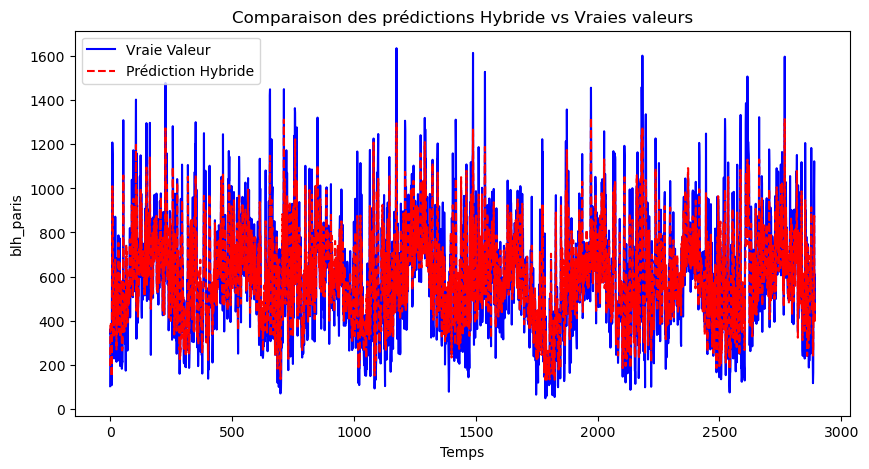

In [ ]:
### ✅ 9. Visualisation des Prédictions ###
plt.figure(figsize=(10,5))
plt.plot(Y_test_lagged.values, label="Vraie Valeur", color='blue')
plt.plot(preds_final, label="Prédiction Hybride", color='red', linestyle='dashed')
plt.title("Comparaison des prédictions Hybride vs Vraies valeurs")
plt.xlabel("Temps")
plt.ylabel(var)
plt.legend()
plt.show()

We achieved an RMSE reduction of approximately 30 and an improvement of 0.13 compared to linear regression.

Good performance, with a reasonable RMSE considering the scale of the variable, and good consistency, demonstrating good generalization.

### Predicting tcc

In [11]:
# Trier les données par date au cas où
var = 'tcc_paris'
X_aligned_tcc = X_aligned.sort_index()
Y_aligned_tcc = Y_aligned.sort_index()

Taille X_train: (11688, 40), Taille X_test: (2922, 40)
Epoch 1/80


c:\Users\moham\Desktop\autres\yessine\Projects\3ATA\Data_Camp\weather station\Weather-Station-Variables-Prediction\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 0.8204
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.6846
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.6472
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.6317
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.6001
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.5918
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.5665
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.5413
Epoch 9/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.5141
Epoch 10/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.5202
Epoch 11/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 0.4830
Epoch 12/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 0.4765
Epoch 13/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 0.4396
Epoch 14/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 0.4145
Epoch 15/80
183/183 ━━━━━━━━━━━━━━━━━━━━

c:\Users\moham\Desktop\autres\yessine\Projects\3ATA\Data_Camp\weather station\Weather-Station-Variables-Prediction\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:28:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 Hybrid Model (LSTM + XGBoost) - RMSE: 0.1437, R²: 0.7373


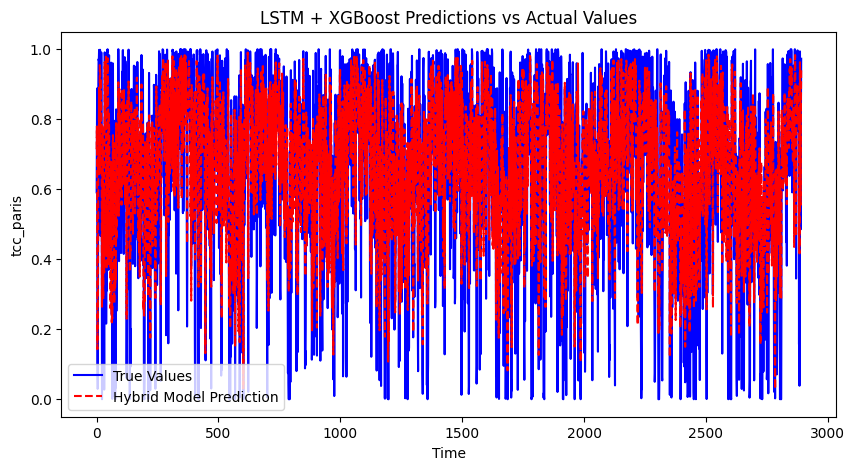

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

### ✅ 1. Define Target Variable ###
var = "tcc_paris"

# Ensure the data is sorted by time
X_aligned_tcc = X_aligned_tcc.sort_index()
Y_aligned_tcc = Y_aligned_tcc.sort_index()

# Train-Test Split (80% Train, 20% Test)
split_index = int(len(X_aligned_tcc) * 0.8)
X_train_tcc, X_test_tcc = X_aligned_tcc.iloc[:split_index], X_aligned_tcc.iloc[split_index:]
Y_train_tcc, Y_test_tcc = Y_aligned_tcc[var].iloc[:split_index], Y_aligned_tcc[var].iloc[split_index:]

print(f"Taille X_train: {X_train_tcc.shape}, Taille X_test: {X_test_tcc.shape}")

### ✅ 2. Feature Selection (Using Random Forest Importance) ###
feature_selector = RandomForestRegressor(n_estimators=100, random_state=42)
feature_selector.fit(X_train_tcc, Y_train_tcc)

# Keep only the most important features (threshold: 0.01 importance)
important_features = X_train_tcc.columns[feature_selector.feature_importances_ > 0.01]
X_train_tcc = X_train_tcc[important_features]
X_test_tcc = X_test_tcc[important_features]

### ✅ 3. Normalization of Data ###
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_tcc)
X_test_scaled = scaler_X.transform(X_test_tcc)
Y_train_scaled = scaler_Y.fit_transform(Y_train_tcc.values.reshape(-1, 1))
Y_test_scaled = scaler_Y.transform(Y_test_tcc.values.reshape(-1, 1))

### ✅ 4. Creating Sequences for LSTM ###
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train_seq, Y_train_seq = create_sequences(X_train_scaled, Y_train_scaled, time_steps)
X_test_seq, Y_test_seq = create_sequences(X_test_scaled, Y_test_scaled, time_steps)

X_train_seq = np.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_test_seq = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

### ✅ 5. Build an Improved LSTM Model (with Bidirectional LSTM) ###
model_lstm = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")

# Train LSTM Model
model_lstm.fit(X_train_seq, Y_train_seq, epochs=80, batch_size=64, verbose=1)

# LSTM Predictions
preds_lstm = model_lstm.predict(X_test_seq)
preds_lstm = scaler_Y.inverse_transform(preds_lstm)
Y_test_seq = scaler_Y.inverse_transform(Y_test_seq.reshape(-1, 1))

### ✅ 6. Feature Engineering for XGBoost ###
def create_lags(y, lags=10):
    df_lagged = pd.DataFrame(y.copy(), columns=[var])
    for lag in range(1, lags + 1):
        df_lagged[f"lag_{lag}"] = df_lagged[var].shift(lag)
    return df_lagged.dropna()

# Apply Lag Features
X_train_lagged = create_lags(Y_train_tcc, lags=10)
X_test_lagged = create_lags(Y_test_tcc, lags=10)

# Align Target Variables
Y_train_lagged = Y_train_tcc.iloc[10:]
Y_test_lagged = Y_test_tcc.iloc[10:]

# Align Sizes After Removing NaN
X_train_lagged, Y_train_lagged = X_train_lagged.align(Y_train_lagged, join='inner', axis=0)
X_test_lagged, Y_test_lagged = X_test_lagged.align(Y_test_lagged, join='inner', axis=0)

### ✅ 7. Train an Optimized XGBoost Model ###
model_xgb = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    lambda_=1,
    alpha=0.1,
    random_state=42,
    n_jobs=-1
)
model_xgb.fit(X_train_lagged, Y_train_lagged)

# XGBoost Predictions
preds_xgb = model_xgb.predict(X_test_lagged)

### ✅ 8. Fusion des Prédictions (Weighted Average) ###
min_length = min(len(preds_lstm), len(preds_xgb))
preds_final = (0.6 * preds_xgb[:min_length] + 0.4 * preds_lstm[:min_length].flatten())
Y_test_lagged = Y_test_lagged.iloc[:min_length]

### ✅ 9. Model Evaluation ###
rmse_hybrid = np.sqrt(mean_squared_error(Y_test_lagged, preds_final))
r2_hybrid = r2_score(Y_test_lagged, preds_final)

print(f"🔹 Hybrid Model (LSTM + XGBoost) - RMSE: {rmse_hybrid:.4f}, R²: {r2_hybrid:.4f}")

### ✅ 10. Visualization ###
plt.figure(figsize=(10,5))
plt.plot(Y_test_lagged.values, label="True Values", color='blue')
plt.plot(preds_final, label="Hybrid Model Prediction", color='red', linestyle='dashed')
plt.title("LSTM + XGBoost Predictions vs Actual Values")
plt.xlabel("Time")
plt.ylabel(var)
plt.legend()
plt.show()


Good performance, with a reasonable RMSE and better than linear regression, which serves as our baseline model.

### Predicting tp

In [23]:
var = 'tp_paris'

initial_model_tp = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_tp.fit(X_train, Y_train[var])

preds_initial_tp = initial_model_tp.predict(X_test)

rmse_init_tp = root_mean_squared_error(Y_test[var], preds_initial_tp)
r2_init_tp = r2_score(Y_test[var], preds_initial_tp)
print(f"{var} - Initial: RMSE={rmse_init_tp:.4f}, R²={r2_init_tp:.4f}")

search_tp = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_tp.fit(X_train, Y_train[var])

best_model_tp = search_tp.best_estimator_
best_model_tp.fit(X_train, Y_train[var])

preds_best_tp = best_model_tp.predict(X_test)

rmse_best_tp = root_mean_squared_error(Y_test[var], preds_best_tp)
r2_best_tp = r2_score(Y_test[var], preds_best_tp)
print(f"{var} - Optimisé: RMSE={rmse_best_tp:.4f}, R²={r2_best_tp:.4f}")
print(f"Meilleurs paramètres : {search_tp.best_params_}")

tp_paris - Initial: RMSE=0.0001, R²=0.3208
tp_paris - Optimisé: RMSE=0.0001, R²=0.3262
Meilleurs paramètres : {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


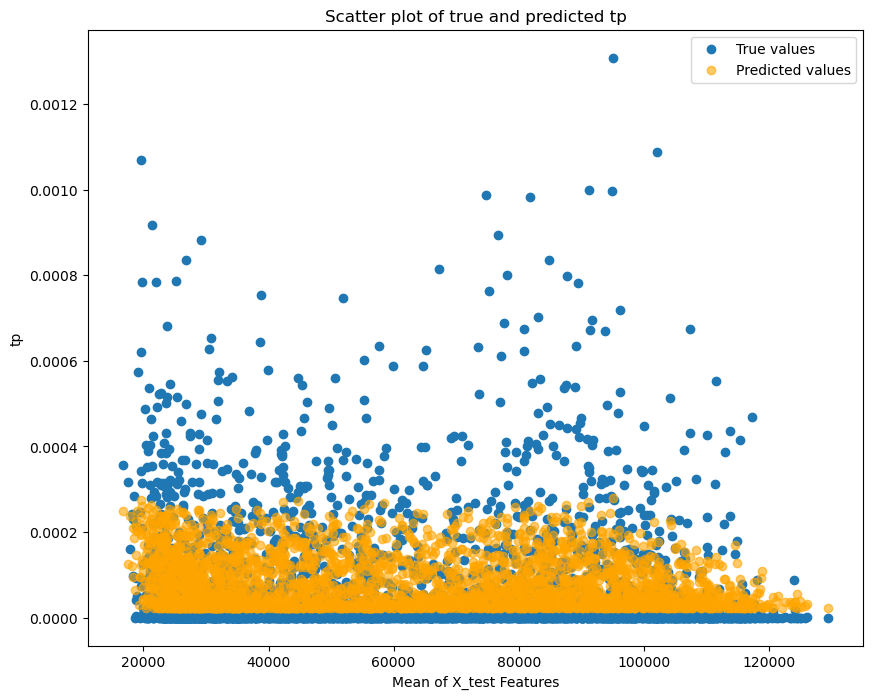

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_tp, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted tp')
plt.xlabel('Mean of X_test Features')
plt.ylabel('tp')
plt.legend()
plt.show()

Poor performances again for tp!

##### Solution: Using two sequential models:
            First model: A binary classification to predict whether precipitation occurs or not.
            Second model: A regression on data where precipitation values are strictly positive, to accurately predict the value of tp.

In [ ]:
print(df_paris_day['tp_paris'].describe())
print(df_paris_day['tp_paris'].head())


count    14976.000000
mean         0.000082
std          0.000147
min          0.000000
25%          0.000000
50%          0.000014
75%          0.000097
max          0.001421
Name: tp_paris, dtype: float64
time
1980-01-01    5.245209e-06
1980-01-02    5.761783e-07
1980-01-03    1.157920e-04
1980-01-04    1.973510e-04
1980-01-05    2.326568e-05
Freq: D, Name: tp_paris, dtype: float32


In [24]:
zeros_per_column_paris_day = (df_paris_day == 0).sum()

total_values_per_column_paris_day = df_paris_day.count()

zero_ratio_paris_day = zeros_per_column_paris_day / total_values_per_column_paris_day

result = pd.DataFrame({
    'Zeros Count': zeros_per_column_paris_day,
    'Total Values': total_values_per_column_paris_day,
    'Zero Ratio': zero_ratio_paris_day
})

print(result)

            Zeros Count  Total Values  Zero Ratio
t2m_paris             0         14976    0.000000
tp_paris           4093         14976    0.273304
skt_paris             0         14976    0.000000
u10_paris             0         14976    0.000000
v10_paris             0         14976    0.000000
d2m_paris             0         14976    0.000000
blh_paris             0         14976    0.000000
sp_paris              0         14976    0.000000
ssrd_paris            0         14976    0.000000
tcc_paris           153         14976    0.010216


In [26]:
import xgboost as xgb

Y_aligned['tp_paris_binary'] = (Y_aligned['tp_paris'] > 0).astype(int)
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X_aligned, Y_aligned['tp_paris_binary'], test_size=0.2, random_state=42
)

clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',  
    eval_metric='logloss',       
    n_estimators=100,      
    learning_rate=0.1,       
    max_depth=6,         
    subsample=0.8,     
    colsample_bytree=0.8,
    random_state=42
)
clf_xgb.fit(X_train, y_train_class)

y_pred_class = clf_xgb.predict(X_test)

print("Classification Accuracy:", accuracy_score(y_test_class,y_pred_class))

Classification Accuracy: 0.840520191649555


In [29]:
# Identify indices where the model predicts rain
rain_indices = X_test.index[y_pred_class == 1]
no_rain_indices = X_test.index[y_pred_class == 0]

# Initialize final predictions with 0 for no-rain cases
y_pred_final = pd.Series(0, index=X_test.index)

# Perform regression only on cases where the classifier predicts rain
X_test_reg = X_test.loc[rain_indices]
y_test_reg = Y_aligned.loc[rain_indices, 'tp_paris']

# Regression model: Random Forest Regressor
non_zero = Y_aligned[Y_aligned['tp_paris'] > 0]
X_reg = X_aligned.loc[non_zero.index]
y_reg = non_zero['tp_paris']

X_train_reg, _, y_train_reg, _ = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

model_tp = RandomForestRegressor(min_samples_split= 2 ,n_estimators=200, random_state=42)
model_tp.fit(X_train_reg,y_train_reg)

# Prédiction sur les cas de pluie
y_pred_reg = model_tp.predict(X_test_reg)

# Insertion des prédictions de régression dans la série finale
y_pred_final.loc[rain_indices] = y_pred_reg

# Calcul des métriques finales
y_test_final = Y_aligned.loc[X_test.index, 'tp_paris']
rmse = np.sqrt(root_mean_squared_error(y_test_final, y_pred_final))
r2 = r2_score(y_test_final, y_pred_final)

print("Final RMSE:", rmse)
print("Final R2 Score:",r2)

Final RMSE: 0.008411596107548866
Final R2 Score: 0.7568956840622532


C:\Users\moham\AppData\Local\Temp\ipykernel_26432\4032385205.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.95766810e-04 3.27704266e-05 8.23308975e-05 ... 5.88963016e-05
 4.65406867e-05 8.06417079e-05]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_pred_final.loc[rain_indices] = y_pred_reg


For the classification model:  We got high accuracy, so can predict well the days without precipitation. 

Also, we obtained better performance for the regression model with reduced overfitting since RMSE increased and R² also improved which means that the model is more generalizable.

However, this does not mean that we achieved optimal results, further optimization can still be performed.